In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from xgboost import XGBClassifier

from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re, string, unicodedata
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense,Input,Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D,Bidirectional, Flatten, BatchNormalization, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import transformers

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (c:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\__init__.py)

In [2]:
data=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df = data.copy()
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Exploratory Data Analysis, text cleaning, and Visualization

In [3]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


<AxesSubplot:xlabel='sentiment', ylabel='count'>

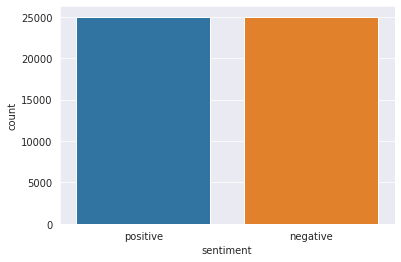

In [4]:
sns.set_style('darkgrid')
sns.countplot(df.sentiment)

- Dataset is balanced

In [5]:
df.isna().sum() # checking for any missing values

review       0
sentiment    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
# duplicates in the data
num_duplicates = df.duplicated().sum()
print("There are {} duplicate reviews present in the dataset".format(num_duplicates))

There are 418 duplicate reviews present in the dataset


In [8]:
review = df['review']
duplicated_review = df[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


In [9]:
stop = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stop.update(punctuations)

In [10]:
# picking random text form review column
sample_text = df.review[8]
sample_text

"Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. <br /><br />The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best performance he at least seems to be making a bit of an effort. One for Keitel obsessives only."

In [11]:
# Removing HTML
soup = BeautifulSoup(sample_text, "html.parser")
sample_text = soup.get_text()
print(sample_text)

Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best performance he at least seems to be making a bit of an effort. One for Keitel obsessives only.


In [12]:
# Replacing sepcial characters and symbols, non-alphabets with sapces
sample_text = re.sub('\[[^]]*\]',' ',sample_text)
sample_text = sample_text.lower() # converting text into lowercase
print(sample_text)

encouraged by the positive comments about this film on here i was looking forward to watching this film. bad mistake. i've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). the film looks cheap and nasty and is boring in the extreme. rarely have i been so happy to see the end credits of a film. the only thing that prevents me giving this a 1-score is harvey keitel - while this is far from his best performance he at least seems to be making a bit of an effort. one for keitel obsessives only.


In [13]:
sample_text = re.sub('[^a-zA-Z]',' ',sample_text)
print(sample_text)

encouraged by the positive comments about this film on here i was looking forward to watching this film  bad mistake  i ve seen      films and this is truly one of the worst of them   it s awful in almost every way  editing  pacing  storyline   acting   soundtrack  the film s only song   a lame country tune   is played no less than four times   the film looks cheap and nasty and is boring in the extreme  rarely have i been so happy to see the end credits of a film  the only thing that prevents me giving this a   score is harvey keitel   while this is far from his best performance he at least seems to be making a bit of an effort  one for keitel obsessives only 


In [14]:
# Removing stop words
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

sample_text = nltk.word_tokenize(sample_text)

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [15]:
sample_text = [word for word in sample_text if not word in set(stopwords.words("english"))]

In [16]:
sample_text

['encouraged',
 'positive',
 'comments',
 'film',
 'looking',
 'forward',
 'watching',
 'film',
 'bad',
 'mistake',
 'seen',
 'films',
 'truly',
 'one',
 'worst',
 'awful',
 'almost',
 'every',
 'way',
 'editing',
 'pacing',
 'storyline',
 'acting',
 'soundtrack',
 'film',
 'song',
 'lame',
 'country',
 'tune',
 'played',
 'less',
 'four',
 'times',
 'film',
 'looks',
 'cheap',
 'nasty',
 'boring',
 'extreme',
 'rarely',
 'happy',
 'see',
 'end',
 'credits',
 'film',
 'thing',
 'prevents',
 'giving',
 'score',
 'harvey',
 'keitel',
 'far',
 'best',
 'performance',
 'least',
 'seems',
 'making',
 'bit',
 'effort',
 'one',
 'keitel',
 'obsessives']

- Like that we will apply this techniques to text data but we will not use tokenizer because the text analysis task is remaining.

In [17]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

# Applying function on review column
df['review'] = df['review'].apply(denoise_text)

In [18]:
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,positive
1,wonderful little filming technique fashion giv...,positive
2,thought wonderful way spend time hot summer si...,positive
3,basically family little boy thinks zombie clos...,negative
4,petter time visually stunning film mattei offe...,positive


In [19]:
# Converting sentiment column in numbers(i.e, 0s or 1s)

df.sentiment.replace("positive",1,inplace=True)
df.sentiment.replace("negative",0,inplace=True)

df.head(10)

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,1
1,wonderful little filming technique fashion giv...,1
2,thought wonderful way spend time hot summer si...,1
3,basically family little boy thinks zombie clos...,0
4,petter time visually stunning film mattei offe...,1
5,probably favorite story sacrifice dedication n...,1
6,sure would like see resurrection dated seahunt...,1
7,show fresh innovative idea first first years t...,0
8,encouraged positive comments film looking forw...,0
9,like original gut wrenching laughter like youn...,1


- Here the data is now cleaned and now we can go forward for Data Analytics

In [20]:
sns.set_style("whitegrid")

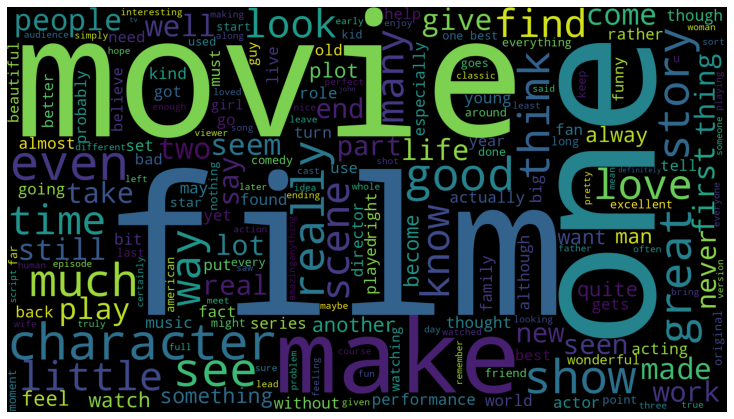

In [21]:
wordcloud = WordCloud(width=1920,height=1080).generate(" ".join(df[df.sentiment==1].review))
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### WordCloud for negative text

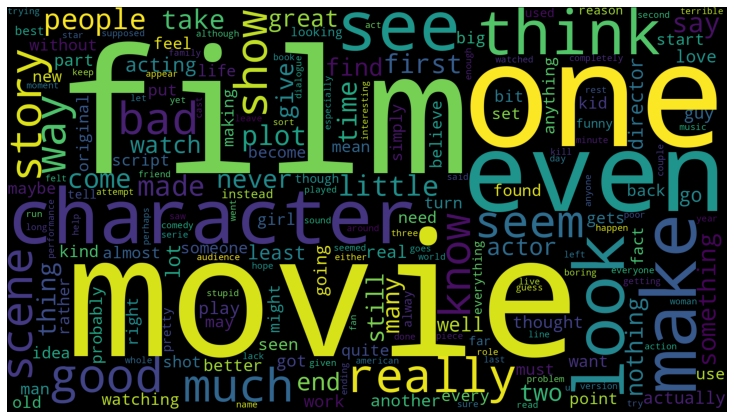

In [22]:
wordcloud = WordCloud(width=1920,height=1080).generate(" ".join(df[df.sentiment==0].review))
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Number of characters in texts

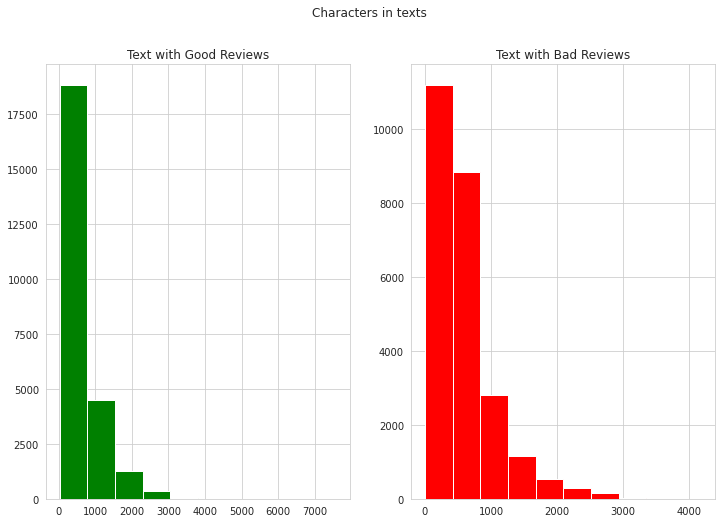

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']==0]['review'].str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Characters in texts')
plt.show()

## Number of words in each text

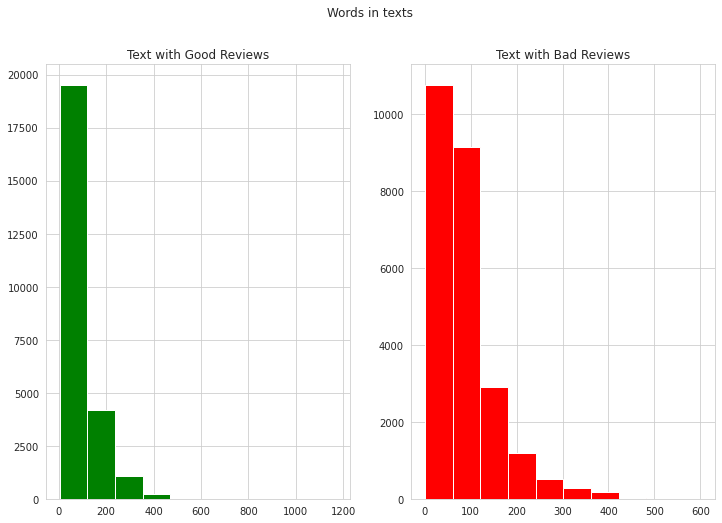

In [24]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']==0]['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Words in texts')
plt.show()

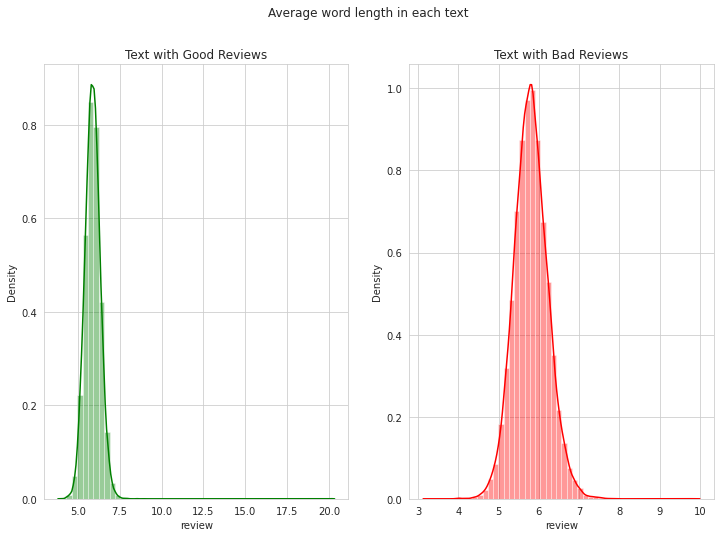

In [25]:
## Average word lenght in a text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
word=df[df['sentiment']==1]['review'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('Text with Good Reviews')
word=df[df['sentiment']==0]['review'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Average word length in each text')
plt.show()

## Analyzing words 

In [26]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]

['one', 'reviewers', 'mentioned', 'watching', 'oz']

##### Most common words

In [27]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'movie': 61496,
 'film': 55088,
 'one': 45067,
 'like': 37303,
 'would': 23815,
 'even': 23720,
 'good': 23475,
 'really': 21806,
 'see': 20906,
 'get': 17692}

In [28]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#### Unigram(single word)

In [29]:
most_common_uni = get_top_text_ngrams(df.review,20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words", "Count"])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words",title="Common Word in Text",orientation='h',width=700,height=700,color='Common_words')
fig.show()

#### Bigram(two words)

In [30]:
most_common_bi = get_top_text_ngrams(df.review,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words", "Count"])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words",title="Common Bigrams in Text",orientation='h',width=700,height=700,color='Common_words')
fig.show()

#### Trigram(Three Words)

In [31]:
most_common_tri = get_top_text_ngrams(df.review,20,3)
most_common_tri = dict(most_common_tri)
temp = pd.DataFrame(columns = ["Common_words", "Count"])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())
fig = px.bar(temp, x="Count", y="Common_words",title="Common Trigrams in Text",orientation='h',width=700,height=700,color='Common_words')
fig.show()

In [32]:
#splitting into train and test
train, test= train_test_split(df, test_size=0.2, random_state=42)
X_train, y_train = train['review'], train['sentiment']
X_test, y_test = test['review'], test['sentiment']

In [33]:
#Vectorizing data

tfidf = TfidfVectorizer() #tfidfVectorizer
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


count_vect = CountVectorizer() # CountVectorizer
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

Logistic Regression Accuracy:  87.72%

Logistic Regresion cross validation score:  87.00%


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4851
           1       0.89      0.87      0.88      5149

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



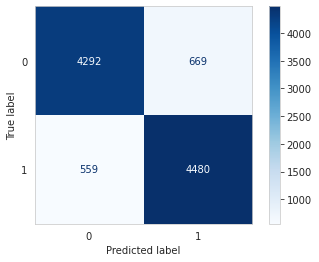

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
pred_lr = lr.predict(X_test_tfidf)
score_lr = accuracy_score(y_test, pred_lr)
lr_cvScore = cross_val_score(lr, X_train_tfidf, y_train, cv=5)
print("Logistic Regression Accuracy: ", "{:.2f}%".format(100*score_lr))
print("\nLogistic Regresion cross validation score: ","{:.2f}%".format(round(lr_cvScore.mean(),2)*100))
print("\n")
plot_confusion_matrix(lr, X_test_tfidf, y_test, cmap='Blues')
plt.grid(False)
print("Classification Report:\n")
print(classification_report(pred_lr,y_test))

Multinomial Naive Bayes Accuracy:  85.05%

Multinomial Naive Bayes cross validation score:  85.00%


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5070
           1       0.84      0.86      0.85      4930

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



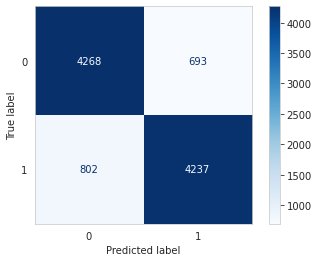

In [35]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
pred_mnb = mnb.predict(X_test_tfidf)
score_mnb = accuracy_score(y_test, pred_mnb)
mnb_cvScore = cross_val_score(mnb, X_train_tfidf, y_train, cv=5)
print("Multinomial Naive Bayes Accuracy: ", "{:.2f}%".format(100*score_mnb))
print("\nMultinomial Naive Bayes cross validation score: ","{:.2f}%".format(round(mnb_cvScore.mean(),2)*100))
print("\n")
plot_confusion_matrix(mnb, X_test_tfidf, y_test, cmap='Blues')
plt.grid(False)
print("Classification Report:\n")
print(classification_report(pred_mnb,y_test))

Linear Support Vectpr Classifier Accuracy:  87.73%

Linear Support Vector Classifier cross validation score:  88.00%


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4866
           1       0.89      0.87      0.88      5134

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



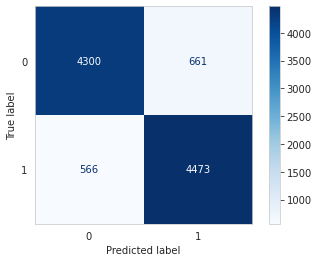

In [36]:
svc = LinearSVC(penalty='l2',loss='hinge')
svc.fit(X_train_tfidf, y_train)
pred_svc = svc.predict(X_test_tfidf)
score_svc = accuracy_score(y_test, pred_svc)
svc_cvScore = cross_val_score(svc, X_train_tfidf, y_train, cv=5)
print("Linear Support Vectpr Classifier Accuracy: ", "{:.2f}%".format(100*score_svc))
print("\nLinear Support Vector Classifier cross validation score: ","{:.2f}%".format(round(svc_cvScore.mean(),2)*100))
print("\n")
plot_confusion_matrix(svc, X_test_tfidf, y_test, cmap='Blues')
plt.grid(False)
print("Classification Report:\n")
print(classification_report(pred_svc,y_test))

## Training the data with Neural Networks

In [45]:
# Function for plotting learning curve
def plotLearningCurve(history,epochs):
    epochRange = range(1,epochs+1)
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    
    ax[0].plot(epochRange,history.history['accuracy'],label='Training Accuracy')
    ax[0].plot(epochRange,history.history['val_accuracy'],label='Validation Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[1].plot(epochRange,history.history['loss'],label='Training Loss')
    ax[1].plot(epochRange, history.history['val_loss'],label='Validation Loss')
    ax[1].set_title('Training and Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    fig.tight_layout()
    plt.show()

In [46]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train, y_train = train['review'], train['sentiment']
X_test, y_test = test['review'], test['sentiment']
#splitting the train set into train and validation
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,
                                             test_size=0.2,random_state=10)

In [47]:
X_train.shape, y_train.shape

((32000,), (32000,))

In [48]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  69948


In [49]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test =  tokenizer.texts_to_sequences(X_test)

In [50]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1171


In [51]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 225


In [52]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.52 % of data


In [53]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [54]:
X_train,X_val,y_train,y_val=train_test_split(pad_train,y_train,
                                             test_size=0.2,random_state=10)

In [55]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()
    
    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_accuracy', 
                                mode='min', 
                               patience = 2 )
    
    checkpoints= tf.keras.callbacks.ModelCheckpoint(filepath='./',
                            monitor="val_accuracy",
                             save_best_only=True
                            )
    callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
#                   callbacks = callbacks)
    print("\nTrain score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs


In [ ]:
D = 64 #embedding dims
epochs = 50
r,model,n_epochs = lstm_model(X_train,X_val,y_train,y_val,V,D,max_seq_len,epochs)

----Building the model----
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 225)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 225, 64)           4476736   
_________________________________________________________________
batch_normalization_2 (Batch (None, 225, 64)           256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 225, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 221, 32)           10272     
_________________________________________________________________
dropout_7 (Dropout)          (None, 221, 32)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (No

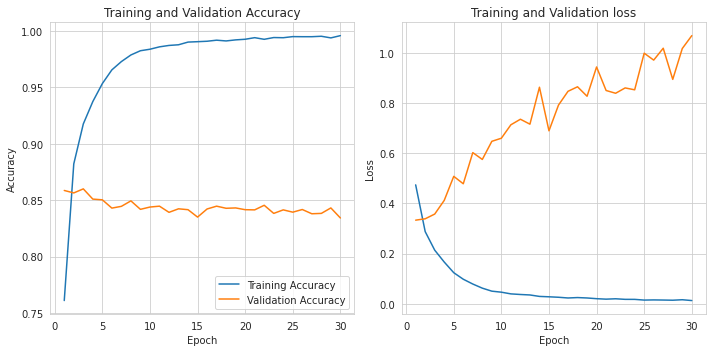

In [60]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [61]:
print("Evaluate Model Performance on Test Set")
result = model.evaluate(pad_test, y_test)

Evaluate Model Performance on Test Set
313/313 [==============================] - 4s 11ms/step - loss: 1.0402 - accuracy: 0.8377


In [ ]:
# Confusion MAtrix 
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("Classification Report:\n")
print(classification_report(y_test,ypred))

In [ ]:
train, test= train_test_split(df, test_size=0.2, random_state=42)
X_train, y_train = train['review'], train['sentiment']
X_test, y_test = test['review'], test['sentiment']
#splitting the train set into train and validation
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,
                                             test_size=0.2,random_state=10)

In [ ]:
#pass our texts to the tokenizer. 
Xtrain_enc = tokenizer(X_train.tolist(), 
                       max_length=max_seq_len, 
                       truncation=True, 
                       padding='max_length', 
                       add_special_tokens=True, 
                       return_tensors='np') #return numpy object

Xval_enc = tokenizer(X_val.tolist(), 
                     max_length=max_seq_len, 
                     truncation=True, 
                     padding='max_length', 
                     add_special_tokens=True, 
                     return_tensors='np') #return numpy object

Xtest_enc = tokenizer(X_test.tolist(), 
                      max_length=max_seq_len, 
                      truncation=True,
                      padding='max_length', 
                      add_special_tokens=True, 
                      return_tensors='np') #return numpy object

In [ ]:
# preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
            dict(Xtrain_enc),
            y_train
))
val_dataset = tf.data.Dataset.from_tensor_slices((
            dict(Xval_enc),
            y_val
))
test_dataset = tf.data.Dataset.from_tensor_slices((
            dict(Xtest_enc),
            y_test
))

In [ ]:
!pip install transformers
from transformers import TFDistilBertModel
transformer = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

In [ ]:
# Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
def bert_model(train_dataset,val_dataset,transformer,max_len,epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid')(x)
    model_bert = Model(inputs=[input_ids,attention_mask], outputs=y)
    model_bert.summary()
    model_bert.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    r_bert = model_bert.fit(train_dataset.batch(32),batch_size = 32,
                  validation_data = val_dataset.batch(32),epochs = epochs)
                  #callbacks = callbacks
    print("\nTrain score:", model_bert.evaluate(train_dataset.batch(32)))
    print("Validation score:", model_bert.evaluate(val_dataset.batch(32)))
    n_epochs_bert = len(r.history['loss'])
    
    return r_bert,model_bert,n_epochs_bert

In [ ]:
epochs=2
max_len = max_seq_len
r_bert, model_bert, n_epochs_bert = bert_model(train_dataset, val_dataset, transformer,max_len,epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model_bert.evaluate(test_dataset.batch(32))
print(dict(zip(model_bert.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model_bert.predict(test_dataset.batch(32))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r_bert.history['loss'], label='Loss')
plt.plot(r_bert.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r_bert.history['accuracy'], label='Accuracy')
plt.plot(r_bert.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')